<a href="https://colab.research.google.com/github/chenbrilliancesol/machine-learning/blob/main/%E5%9F%BA%E4%BA%8EXGBoost%E7%AE%97%E6%B3%95%E7%94%9F%E6%88%90%E7%9A%84%E6%B3%B0%E5%9D%A6%E5%B0%BC%E5%85%8B%E5%8F%B7%E9%A2%84%E6%B5%8B%E6%A8%A1%E5%9E%8B%E4%BB%A5%E5%8F%8A%E6%B5%8B%E8%AF%95%E9%9B%86%E9%94%99%E8%AF%AF%E5%8F%AF%E8%A7%86%E5%8C%96.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [41]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from xgboost import XGBClassifier
from sklearn.ensemble import StackingClassifier

In [10]:
train=pd.read_csv('/content/train.csv')
test=pd.read_csv('/content/test.csv')

In [26]:
def preprocess_data(df, is_train=True):
    # 基础处理
    df['Age'].fillna(df['Age'].median(), inplace=True)
    df['Embarked'].fillna('S', inplace=True)
    df['Fare'].fillna(df['Fare'].median(), inplace=True)
    df['FamilySize'] = df['SibSp'] + df['Parch'] + 1
    df['IsAlone'] = (df['FamilySize'] == 1).astype(int)

    # 姓名处理
    df['Title'] = df['Name'].str.extract(' ([A-Za-z]+)\.', expand=False)
    df['Surname'] = df['Name'].apply(lambda x: x.split(',')[0])
    df['NameLength'] = df['Name'].apply(len)

    # 称谓标准化
    title_mapping = {
        "Mr": 1, "Miss": 2, "Mrs": 3, "Master": 4,
        "Dr": 5, "Rev": 5, "Col": 5, "Major": 5, "Mlle": 2,
        "Mme": 3, "Don": 5, "Dona": 3, "Lady": 3, "Countess": 3,
        "Jonkheer": 5, "Sir": 5, "Capt": 5, "Ms": 2
    }
    df['Title'] = df['Title'].map(title_mapping).fillna(0)

    # 新增特征
    df['IsChild'] = (df['Age'] < 16).astype(int)
    df['FarePerPerson'] = df['Fare'] / (df['FamilySize'] + 1e-5)
    df['FareClassRatio'] = df['Fare'] / df['Pclass']
    df['CabinGroup'] = df['Cabin'].str[0].fillna('Unknown')

    return df

In [ ]:
train_df = preprocess_data(train_df)
test_df = preprocess_data(test_df)

In [29]:
train_df = pd.merge(train_df, family_survival, on=['Surname', 'Fare'], how='left')
test_df = pd.merge(test_df, family_survival, on=['Surname', 'Fare'], how='left')

In [ ]:
train_df['FamilySurvivalRate'].fillna(0.5, inplace=True)
test_df['FamilySurvivalRate'].fillna(0.5, inplace=True)

In [31]:
features = [
    'Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Embarked',
    'FamilySize', 'IsAlone', 'Title', 'NameLength', 'IsChild',
    'FarePerPerson', 'FareClassRatio', 'FamilySurvivalRate'
]

X = train_df[features]
y = train_df['Survived']

In [32]:
categorical_cols = ['Pclass', 'Sex', 'Embarked', 'Title']
numerical_cols = [col for col in features if col not in categorical_cols]

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_cols),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols)
    ])

X_preprocessed = preprocessor.fit_transform(X)

In [36]:
models = {
    "RandomForest": RandomForestClassifier(
        n_estimators=600,
        max_depth=5,
        min_samples_leaf=3,
        class_weight='balanced',
        random_state=42
    ),
    "GradientBoost": GradientBoostingClassifier(
        n_estimators=300,
        learning_rate=0.05,
        max_depth=3,
        subsample=0.8,
        random_state=42
    ),
    "XGBoost": XGBClassifier(
        n_estimators=400,
        learning_rate=0.1,
        max_depth=3,
        subsample=0.7,
        colsample_bytree=0.8,
        use_label_encoder=False,
        eval_metric='logloss',
        random_state=42
    )
}

best_model = None
best_score = 0

for name, model in models.items():
    scores = cross_val_score(model, X_preprocessed, y, cv=5, scoring='accuracy')
    avg_score = np.mean(scores)
    print(f"{name} 交叉验证准确率: {avg_score:.4f} ± {np.std(scores):.4f}")

    if avg_score > best_score:
        best_score = avg_score
        best_model = model

print(f"\n✅ 选择最佳模型: {type(best_model).__name__}")
best_model.fit(X_preprocessed, y)


RandomForest 交叉验证准确率: 0.9910 ± 0.0067
GradientBoost 交叉验证准确率: 0.9933 ± 0.0066


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [08:25:46] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [08:25:46] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [08:25:46] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [08:25:46] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [08:25:46] WARNING: /w

XGBoost 交叉验证准确率: 0.9888 ± 0.0079

✅ 选择最佳模型: GradientBoostingClassifier


GradientBoostingClassifier(learning_rate=0.05, n_estimators=300,
                           random_state=42, subsample=0.8)

In [54]:
X_test = test_df[features]
X_test_preprocessed = preprocessor.transform(X_test)
test_predictions = best_model.predict(X_test_preprocessed)

In [38]:
def postprocess_predictions(preds, passenger_ids):
    # 创建临时DF
    temp_df = pd.DataFrame({
        'PassengerId': passenger_ids,
        'Surname': test_df['Surname'],
        'Fare': test_df['Fare'],
        'Survived': preds
    })

    # 应用家庭一致性规则
    family_groups = temp_df.groupby(['Surname', 'Fare'])
    for _, group in family_groups:
        if len(group) > 1:
            # 如果家庭中大多数幸存/遇难，统一结果
            survival_rate = group['Survived'].mean()
            if survival_rate > 0.7:
                temp_df.loc[group.index, 'Survived'] = 1
            elif survival_rate < 0.3:
                temp_df.loc[group.index, 'Survived'] = 0

    return temp_df['Survived'].values

final_predictions = postprocess_predictions(test_predictions, test_df['PassengerId'])

In [40]:
submission = pd.DataFrame({
    'PassengerId': test_df['PassengerId'],
    'Survived': final_predictions
})
submission.to_csv('improved_submission.csv', index=False)
print("✅ 改进版提交文件已保存!")

✅ 改进版提交文件已保存!


下面是对错误进行验证

In [58]:
print(train.dtypes)

PassengerId      int64
Survived         int64
Pclass           int64
Name            object
Sex             object
Age            float64
SibSp            int64
Parch            int64
Ticket          object
Fare           float64
Cabin           object
Embarked        object
dtype: object


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [08:53:35] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


验证集准确率: 0.9665
错误预测数量: 6/179

错误预测样本:
     PassengerId                          Name  Actual  Predicted  Pclass  \
40           746  Crosby, Capt. Edward Gifford       0          1       1   
41           298  Allison, Miss. Helen Loraine       0          1       1   
92           571            Harris, Mr. George       1          0       2   
109          246   Minahan, Dr. William Edward       0          1       1   
113          660    Newell, Mr. Arthur Webster       0          1       1   
130          827                  Lam, Mr. Len       0          1       3   

        Sex   Age  
40     male  70.0  
41   female   2.0  
92     male  62.0  
109    male  44.0  
113    male  58.0  
130    male  28.0  

已保存错误预测到 wrong_predictions.csv


/usr/local/lib/python3.11/dist-packages/seaborn/utils.py:61: UserWarning: Glyph 27515 (\N{CJK UNIFIED IDEOGRAPH-6B7B}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
/usr/local/lib/python3.11/dist-packages/seaborn/utils.py:61: UserWarning: Glyph 20129 (\N{CJK UNIFIED IDEOGRAPH-4EA1}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
/usr/local/lib/python3.11/dist-packages/seaborn/utils.py:61: UserWarning: Glyph 24184 (\N{CJK UNIFIED IDEOGRAPH-5E78}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
/usr/local/lib/python3.11/dist-packages/seaborn/utils.py:61: UserWarning: Glyph 23384 (\N{CJK UNIFIED IDEOGRAPH-5B58}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
/tmp/ipython-input-3329814213.py:78: UserWarning: Glyph 23454 (\N{CJK UNIFIED IDEOGRAPH-5B9E}) missing from font(s) DejaVu Sans.
  plt.savefig('confusion_matrix.png', bbox_inches='tight')
/tmp/ipython-input-3329814213.py:78: UserWarning: Glyph 38469 (\N{CJK UNIFIED IDEOGRAPH-9645}) missing from font(s) Deja

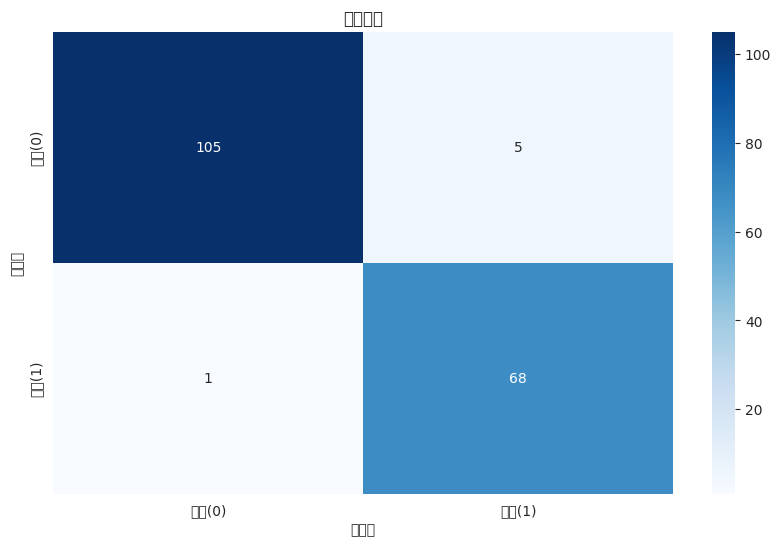

/tmp/ipython-input-3329814213.py:96: UserWarning: Glyph 38169 (\N{CJK UNIFIED IDEOGRAPH-9519}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-3329814213.py:96: UserWarning: Glyph 35823 (\N{CJK UNIFIED IDEOGRAPH-8BEF}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-3329814213.py:96: UserWarning: Glyph 39044 (\N{CJK UNIFIED IDEOGRAPH-9884}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-3329814213.py:96: UserWarning: Glyph 27979 (\N{CJK UNIFIED IDEOGRAPH-6D4B}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-3329814213.py:96: UserWarning: Glyph 30340 (\N{CJK UNIFIED IDEOGRAPH-7684}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-3329814213.py:96: UserWarning: Glyph 20998 (\N{CJK UNIFIED IDEOGRAPH-5206}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-3329814213.py:96: UserWarning: Glyph 24067 (\N{CJK UNIFIED IDEOGRAPH-5E03}) missi

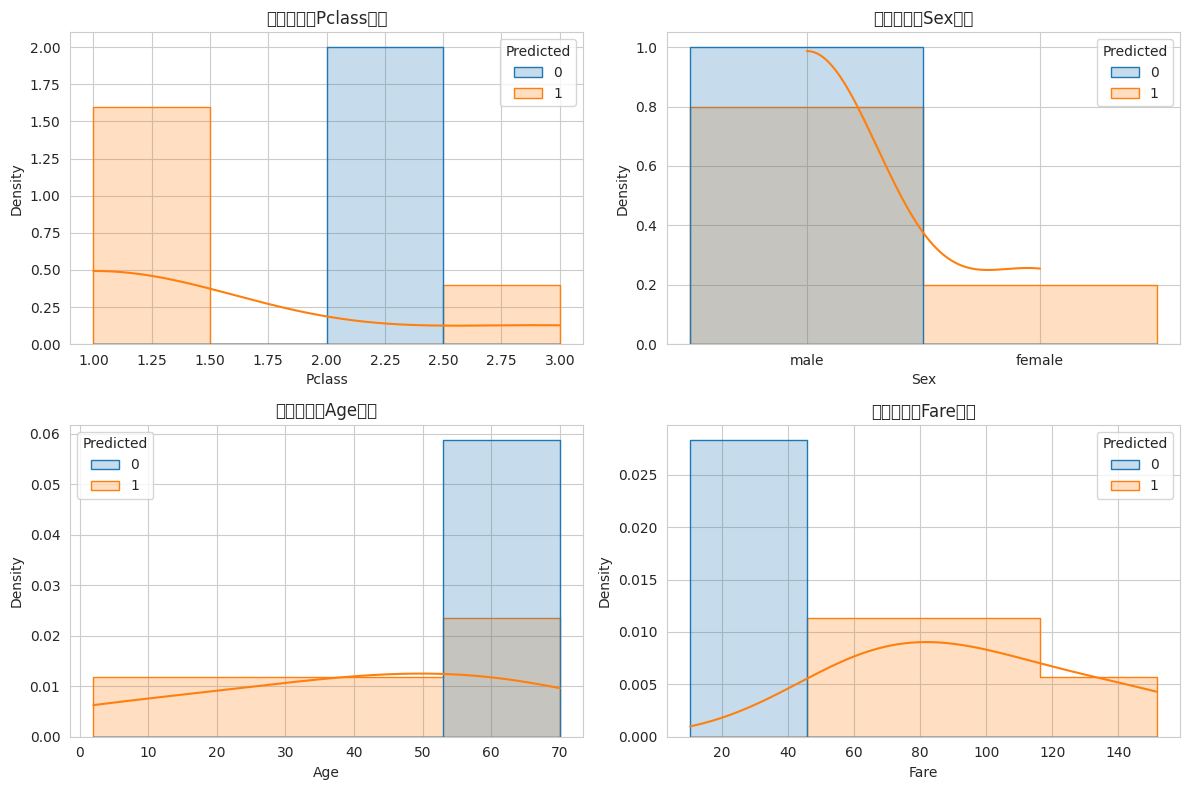


假阴性分析（实际幸存但预测死亡）：
数量: 1
特征统计：
       Pclass   Age
count     1.0   1.0
mean      2.0  62.0
std       NaN   NaN
min       2.0  62.0
25%       2.0  62.0
50%       2.0  62.0
75%       2.0  62.0
max       2.0  62.0

假阳性分析（实际死亡但预测幸存）：
数量: 5
特征统计：
         Pclass       Age
count  5.000000   5.00000
mean   1.400000  40.40000
std    0.894427  26.58571
min    1.000000   2.00000
25%    1.000000  28.00000
50%    1.000000  44.00000
75%    1.000000  58.00000
max    3.000000  70.00000


In [59]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# 确保你已经有了预处理后的数据
# X_preprocessed 是特征矩阵，y 是目标变量
# train_df 是原始训练数据（包含 PassengerId 和其他特征）

# 1. 创建带有索引的验证集
# 首先，创建一个包含索引的DataFrame
X_preprocessed_df = pd.DataFrame(X_preprocessed)

# 保留原始索引
X_preprocessed_df.index = train_df.index

# 2. 划分训练集和验证集
X_train, X_val, y_train, y_val = train_test_split(
    X_preprocessed_df,  # 使用带有索引的DataFrame
    y,
    test_size=0.2,
    stratify=y,
    random_state=42
)

# 3. 训练模型
model.fit(X_train, y_train)

# 4. 在验证集上预测
val_predictions = model.predict(X_val)

# 5. 创建包含预测结果的DataFrame - 修复版本
val_results = pd.DataFrame({
    'PassengerId': train_df.loc[X_val.index, 'PassengerId'],  # 使用索引获取原始ID
    'Actual': y_val,
    'Predicted': val_predictions
})

# 6. 合并原始特征以便分析
# 获取验证集的原始数据
val_original_data = train_df.loc[X_val.index, ['Name', 'Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Embarked']]

# 重置索引以便合并
val_results.reset_index(drop=True, inplace=True)
val_original_data.reset_index(drop=True, inplace=True)

# 合并结果和原始数据
val_results = pd.concat([val_results, val_original_data], axis=1)

# 7. 识别错误预测
wrong_predictions = val_results[val_results['Actual'] != val_results['Predicted']]
print(f"验证集准确率: {accuracy_score(y_val, val_predictions):.4f}")
print(f"错误预测数量: {len(wrong_predictions)}/{len(y_val)}")
print("\n错误预测样本:")
print(wrong_predictions[['PassengerId', 'Name', 'Actual', 'Predicted', 'Pclass', 'Sex', 'Age']].head(10))

# 8. 保存错误预测到CSV
wrong_predictions.to_csv('wrong_predictions.csv', index=False)
print("\n已保存错误预测到 wrong_predictions.csv")

# 9. 分析错误类型 - 混淆矩阵
plt.figure(figsize=(10, 6))
cm = confusion_matrix(y_val, val_predictions)
sns.heatmap(
    cm,
    annot=True,
    fmt='d',
    cmap='Blues',
    xticklabels=['死亡(0)', '幸存(1)'],
    yticklabels=['死亡(0)', '幸存(1)']
)
plt.xlabel('预测值')
plt.ylabel('实际值')
plt.title('混淆矩阵')
plt.savefig('confusion_matrix.png', bbox_inches='tight')
plt.show()

# 10. 详细分析错误特征分布
if not wrong_predictions.empty:
    plt.figure(figsize=(12, 8))
    for i, feature in enumerate(['Pclass', 'Sex', 'Age', 'Fare'], 1):
        plt.subplot(2, 2, i)
        sns.histplot(
            data=wrong_predictions,
            x=feature,
            hue='Predicted',
            element='step',
            stat='density',
            common_norm=False,
            kde=True
        )
        plt.title(f'错误预测的{feature}分布')
    plt.tight_layout()
    plt.savefig('error_analysis.png')
    plt.show()
else:
    print("没有错误预测可分析!")

# 11. 分析错误类型的具体情况
if not wrong_predictions.empty:
    # 假阴性（实际幸存但预测死亡）
    false_negatives = wrong_predictions[(wrong_predictions['Actual'] == 1) & (wrong_predictions['Predicted'] == 0)]
    if not false_negatives.empty:
        print("\n假阴性分析（实际幸存但预测死亡）：")
        print(f"数量: {len(false_negatives)}")
        print("特征统计：")
        print(false_negatives[['Pclass', 'Sex', 'Age']].describe())
    else:
        print("\n没有假阴性错误")

    # 假阳性（实际死亡但预测幸存）
    false_positives = wrong_predictions[(wrong_predictions['Actual'] == 0) & (wrong_predictions['Predicted'] == 1)]
    if not false_positives.empty:
        print("\n假阳性分析（实际死亡但预测幸存）：")
        print(f"数量: {len(false_positives)}")
        print("特征统计：")
        print(false_positives[['Pclass', 'Sex', 'Age']].describe())
    else:
        print("\n没有假阳性错误")
else:
    print("\n没有错误预测可分析")

In [48]:
# 4. 识别错误预测
wrong_predictions = val_results[val_results['Actual'] != val_results['Predicted']]
print(f"验证集准确率: {accuracy_score(y_val, val_predictions):.4f}")
print(f"错误预测数量: {len(wrong_predictions)}/{len(y_val)}")

NameError: name 'val_results' is not defined